In [1]:
import jax 
import jax.numpy as jnp

def f(Z,mpd):

    gp = mpd.gp

    K_XX,K_xX_dx,K_XX_inv,L_XX,mean_d= gp.info_factors(gp.params,
                                                        gp.mean_state,gp.kernel_state,
                                                        mpd.x,gp.X,gp.y)

    rng = jax.random.PRNGKey(3)
    
    info = jax.vmap(gp.info,in_axes=(0,
                                    None,None,None,
                                    None,None,None,
                                    None,None,None,None,None))


    return -info(Z,
        gp.params,gp.mean_state,gp.kernel_state,
        mpd.x,gp.X,gp.y,      
        K_XX,L_XX,K_XX_inv,K_xX_dx,mean_d
    )

def grad(x_t,mpd):
    gp = mpd.gp
    d = gp.X.shape[-1]
    
    MX = gp.mean.__call__(gp.params,gp.mean_state,gp.X,)
    K_XX = gp.kernel.__call__(gp.params,gp.kernel_state,gp.X,gp.X,) 
    Mx_dx = jax.grad(gp.mean.__call__,argnums=2)(gp.params,gp.mean_state,x_t).reshape(-1,1)
    KxX_dx = jax.jacrev(gp.kernel.__call__,argnums=2)(gp.params,gp.kernel_state,x_t,gp.X).squeeze().reshape(-1,d) ##[n,d]
    y_d = gp.y.reshape(-1,1)- MX.reshape(-1,1) 

    mean_d = Mx_dx + KxX_dx.T @ jax.scipy.linalg.solve(K_XX,y_d,assume_a="pos")
    ### Rescale gradients to make plots clearer###
    ### Only the direction matters ###
    mean_d = mean_d * 0.004
    Mx_dx = Mx_dx * 0.004
    #####################
 
    print(f'MX {MX} Mx_dx {Mx_dx.squeeze()} mean_d {mean_d.squeeze()}')

    return Mx_dx.squeeze() , mean_d.squeeze()

In [3]:

from pylab import figure, cm

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({'font.size': 14})

def plot(mpd,x_acq,j,R2,seed,outputscale,noise):

    x_t=  mpd.x.squeeze()
    X = mpd.gp.X
    delta = 0.05
    x_min = - delta+ x_t[0]
    x_max =delta + x_t[0]
    y_min = -delta + x_t[1]
    y_max =delta + x_t[1]
    dx,dy = 5e-4,5e-4

    nx = int((x_max-x_min)/dx)

    ny = int((y_max-y_min)/dy)

    x, y = np.meshgrid(np.linspace(x_min,x_max, nx), np.linspace(y_min,y_max, ny))



    Z = np.stack([x,y]).T
    Z = Z.reshape((-1,2))-x_t.squeeze()


    f_Z = f(Z,mpd).reshape((nx,ny))

    f_x = f(x_acq.reshape(1,-1)-x_t.reshape(1,-1),mpd)

    mean_d,corrected_mean_d = grad(mpd.x,mpd)

    plt.imshow(f_Z.T,extent=[x_min,x_max,y_min,y_max], cmap=cm.jet, origin='lower')

    #plt.colorbar()

    
    # n = ["z_"+str(i) for i in range(len(X)-1)]
    # for i, txt in enumerate(n):
    #     plt.annotate(txt, (X[i+1,0], X[i+1,1]),color="white")
    
    
    
    plt.scatter(x_t[0],x_t[1], marker="*",label=r'$\theta$',color="darkorange",s=200)  #creates plot with star marker

    plt.scatter(X[1:,0],X[1:,1],marker="X",color="white")
    
    plt.scatter(x_acq[0],x_acq[1], marker="X",label=r'$z$',color="darkturquoise")  #creates plot with star marker


    plt.arrow(x_t[0], x_t[1], mean_d[0], mean_d[1],color="violet",#color="grey",
              label=r'$\nabla_\theta m$')

    plt.arrow(x_t[0], x_t[1], corrected_mean_d[0], corrected_mean_d[1],color="purple",#color="black",
                      label=r'$\mu_\theta$')


    #plt.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",mode="expand",ncol=4)

    if len(X)==2:
        plt.legend(#box_to_anchor=(0,1.02,1,0.2),
                loc="upper left",mode="expand",ncol=4)
                
        
        ax = plt.gca()
        leg = ax.get_legend()
        hl_dict = {handle.get_label(): handle for handle in leg.legendHandles}
        print(f'HL DICT {hl_dict}')
        print(f'HL DICT {hl_dict.keys()}')
        hl_dict['$z$'].set_color('white')
      
            
    
    plt.savefig('./plots/plot'+str(seed)+"_"+str(j)+".png")

    
    plt.show()  


I0000 00:00:1709857495.545032 2038899 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
2024-03-08 01:24:55.654280: W external/xla/xla/service/gpu/nvptx_compiler.cc:708] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


ParameterReshaper: 2 parameters detected for optimization.
first time
Code block 'Fit critic on new policy' took: 3.0246428919490427 s
Code block 'Gp fit new policy' took: 3.747059963643551e-06 s
Code block 'Gp ask neighbours' took: 9.567539421026595 s
MX -0.7926021575404062 Mx_dx [-0.00771538 -0.00770166] mean_d [-0.00771538 -0.00770166]


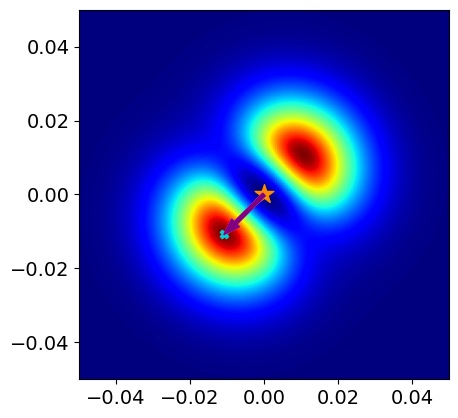

R2  [-99. -99. -99. -99. -99.]
Code block 'Fit critic on new policy' took: 6.124111982993782 s
Code block 'Gp fit neighbours' took: 6.0661354379262775 s
Code block 'Gp ask neighbours' took: 8.914403344038874 s
MX [-0.79260216 -0.76439013] Mx_dx [-0.00252222 -0.00054666] mean_d [0.00566256 0.00759474]
HL DICT {'$\\theta$': <matplotlib.collections.PathCollection object at 0x7f1fd077d600>, '$z$': <matplotlib.collections.PathCollection object at 0x7f1fd077fb20>, '$\\nabla_\\theta m$': <matplotlib.patches.Rectangle object at 0x7f1fd077e230>, '$\\mu_\\theta$': <matplotlib.patches.Rectangle object at 0x7f1f90486fe0>}
HL DICT dict_keys(['$\\theta$', '$z$', '$\\nabla_\\theta m$', '$\\mu_\\theta$'])


/tmp/ipykernel_2038899/1338844642.py:71: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  hl_dict = {handle.get_label(): handle for handle in leg.legendHandles}


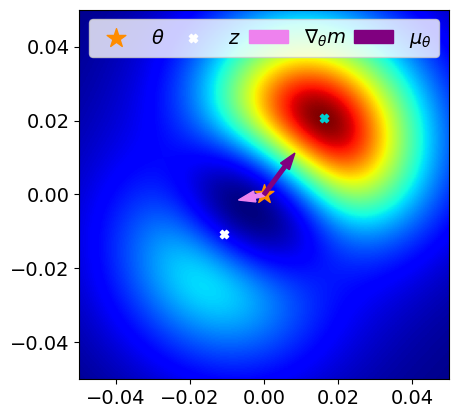

R2  [-2.7160556 -2.6508949 -1.2843809 -1.3251069 -1.7576089]
Code block 'Fit critic on new policy' took: 5.300828472012654 s
Code block 'Gp fit neighbours' took: 5.79268042196054 s
Code block 'Gp ask neighbours' took: 8.49432787601836 s
MX [-0.79260215 -0.76298513 -0.72118781] Mx_dx [-0.00583395  0.0047395 ] mean_d [-0.00167978  0.00765022]


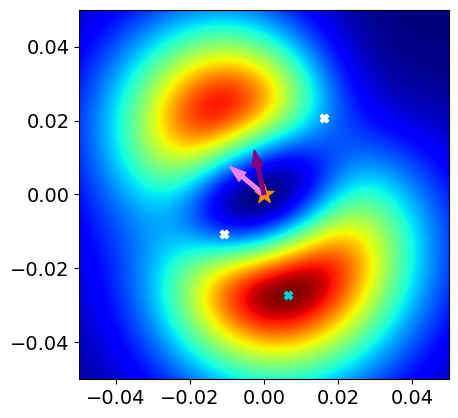

R2  [-0.41754532 -1.4169297  -1.6968453  -1.2035766  -2.3164766 ]
Code block 'Fit critic on new policy' took: 5.303475489956327 s
Code block 'Gp fit neighbours' took: 6.193573210039176 s
Code block 'Gp ask neighbours' took: 9.002900001010858 s
MX [-0.79260217 -0.73706396 -0.65130608 -0.69230535] Mx_dx [-0.0095873  -0.01307997] mean_d [-0.01406644 -0.00293876]


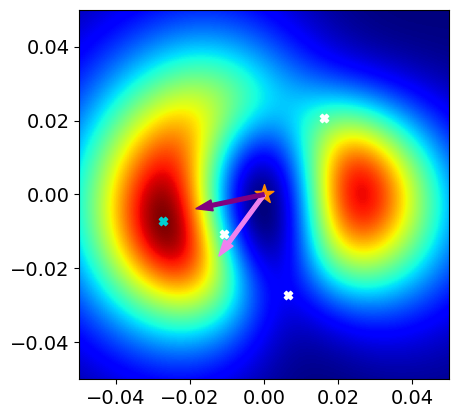

R2  [-6.6402235 -5.175634  -3.4028683 -3.7991962 -4.846256 ]
Code block 'Fit critic on new policy' took: 5.324567604926415 s
Code block 'Gp fit neighbours' took: 6.574838191037998 s
y_acq_disc -0.8711080258303519


In [4]:

import itertools
import numpy as np
import os

# Set env variables
os.environ["WANDB_API_KEY"]="28996bd59f1ba2c5a8c3f2cc23d8673c327ae230"
os.environ['PYTHONHASHSEED'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'


##############################
project_name = "delete"
algo_name = "abs"
task_name = "pd" #"mountaincar"
#seeds = [610]
seeds = [6101969]
#seeds = [21061998]
#seeds = [4091997]
lengthscale_bound = [(0.00125,0.025)]
learning_rate = [0.005] ##0.0025


cfg = itertools.product(seeds,[task_name],[project_name],[algo_name],learning_rate,lengthscale_bound)
config = next(cfg)
   
        
import os
import random
import numpy
import jax
import jax.numpy as jnp
from jax.config import config as cfg

seed = config[0]
random.seed(seed)
np.random.seed(seed)

cfg.update("jax_enable_x64", True)
cfg.update('jax_default_matmul_precision', jax.lax.Precision.HIGHEST)        

from src.setup import get_mpd_cfgs,setup_mpd,setup_ars
from src.fitness import fitness_acq,fitness_center,update_norm

configs = get_mpd_cfgs(*config)

mpd,evaluator,logger,param_reshaper,rng = setup_mpd(*configs,use_wandb=False)

num_rollouts,num_rollouts_center = mpd.num_rollouts,mpd.num_rollouts_center  
normalizer_params = evaluator.normalizer_params


if config[3]in ["abs","ddpgn"]:

            mpd.gp.mean_state = mpd.gp.mean_state.replace(obs_params=normalizer_params)

ascent_prob = 1.

for i in range(1):
    
    
        
    if i == 0 :
                
            x_acq = mpd.gp.sigma * jax.random.normal(rng,(100,mpd.n_dims))
            y_acq,states_acq,masks_acq,transitions_acq,noise_acq = fitness_acq(evaluator,
                                                                    param_reshaper,x_acq,normalizer_params,num_rollouts=mpd.num_rollouts)
                           
            states_acq = states_acq.reshape((-1,*states_acq.shape[2:]))
            masks_acq = masks_acq.reshape((-1,*masks_acq.shape[2:]))
            mpd.gp.mean.append_train_data(x_acq,y_acq,states_acq,masks_acq,transitions_acq)        
            
            

    if i>0 : 
        

        ### Take gradient step
        x_old = mpd.x
        x_t,ascent_prob = mpd.ask_local()
        normalizer_params = update_norm(normalizer_params,obs_acq,mask_acq!=0)
        if config[3] in ["abs","ddpgn"]:
            mpd.gp.mean_state = mpd.gp.mean_state.replace(obs_params=normalizer_params)
        

    else : 
        
        x_t = jnp.zeros((1,mpd.n_dims))
        x_old = x_t
        
        
    y_t,noise_t,obs_t, mask_t,transitions_t= fitness_center(
                                            evaluator,
                                            param_reshaper,x_t,normalizer_params,
                                            num_rollouts_center)

    mpd.tell_local(rng,x_t,y_t,noise_t,
                    obs_t,mask_t,tuple(transitions_t),obs_params=normalizer_params,
                    )
    
    
        
    x_acq_tmp,y_acq_tmp,obs_acq_tmp,mask_acq_tmp = [],[],[],[]
        
    for j in range(mpd.n_info//mpd.n_parallel):

            rng,_ =  jax.random.split(rng)
            
            
            a = mpd.gp.params["noise"]
            b = mpd.gp.params["outputscale"]
            mpd.gp.params["noise"]= np.min([a,b/2])
            x_acq,x_acq_info,info_gain = mpd.ask_neighbours(rng,mpd.n_parallel)
            
            y_acq,obs_acq,mask_acq,transitions_acq,noise_acq = fitness_acq(evaluator,
                                                            param_reshaper,x_acq,normalizer_params,num_rollouts=mpd.num_rollouts)
            
            y = mpd.gp.y
            y_pred = mpd.gp.mean.__call__(mpd.gp.params,mpd.gp.mean_state,mpd.gp.X)
            y,y_pred = np.array(y),np.array(y_pred)
            y_pred = y_pred.reshape(-1,1)
            a2 = ((y-y_pred)**2).sum()
            b2=((y-y.mean())**2).sum()+1e-4
            R2 = 1-(a2/b2)

            
            plot(mpd,x_acq.squeeze(),j,R2,seed,mpd.gp.params["outputscale"],mpd.gp.params["noise"])

            
            
            
            mpd.tell_neighbours(rng,x_acq,y_acq,noise_acq,
                                obs_acq,mask_acq,tuple(transitions_acq))
            
            
            

            x_acq_tmp.append(x_acq)
            y_acq_tmp.append(y_acq)
            obs_acq_tmp.append(obs_acq)
            mask_acq_tmp.append(mask_acq)
        
    x_acq = jnp.vstack(x_acq_tmp)
    y_acq = jnp.vstack(y_acq_tmp)
    obs_acq = jnp.vstack(obs_acq_tmp)
    mask_acq = jnp.vstack(mask_acq_tmp)
    print("y_acq_disc",y_acq.mean())
        
    rng,_ =  jax.random.split(rng)
        
        
